# UNet model
### belhaddad mohamed islem & saim ouail
## Dataset link [CVC-ClinicDB](https://www.kaggle.com/balraj98 cvcclinicdb)

In [2]:


# Move the uploaded 'kaggle.json' file to the correct directory using the following code:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

# Info on how to get your api key (kaggle.json) here: https://github.com/Kaggle/kaggle-api#api-credentials
!pip install kaggle

# Set the appropriate permissions for the kaggle.json file using the following code:
!chmod 600 ~/.kaggle/kaggle.json

# Download datasets
!kaggle datasets download -d balraj98/cvcclinicdb


# Unzip it
!unzip /content/cvcclinicdb

# Remove Zip file
# os.remove("/content/nct-crc-he-100k.zip")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 85% 111M/131M [00:00<00:00, 218MB/s] 
100% 131M/131M [00:00<00:00, 210MB/s]
Archive:  /content/cvcclinicdb.zip
  inflating: PNG/Ground Truth/1.png  
  inflating: PNG/Ground Truth/10.png  
  inflating: PNG/Ground Truth/100.png  
  inflating: PNG/Ground Truth/101.png  
  inflating: PNG/Ground Truth/102.png  
  inflating: PNG/Ground Truth/103.png  
  inflating: PNG/Ground Truth/104.png  
  inflating: PNG/Ground Truth/105.png  
  inflating: PNG/Ground Truth/106.png  
  inflating: PNG/Ground Truth/107.png  
  inflating: PNG/Ground Truth/108.png  
  inflating: PNG/Ground Truth/109.png  
  inflating: PNG/Ground Truth/11.png  
  inflating: PNG/Ground Truth/110.png  
  inflating: PNG/Ground Truth/111.png  
  inflating: PNG/Ground Truth/112.png  
  inflating: PNG/Ground Truth/113.png  
  inflating: PNG/Ground Truth/114.png  
  inflating: PNG/Ground Truth/115.png  
  inflating: PNG/Ground Truth/116

### import Libraries

In [3]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

In [6]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp

In [7]:
# !pip install --upgrade pip

### Read Data & Create train / valid splits

In [8]:
DATA_DIR = '/content/'

metadata_df = pd.read_csv(os.path.join(DATA_DIR, 'metadata.csv'))
metadata_df = metadata_df[['frame_id', 'png_image_path', 'png_mask_path']]
metadata_df['png_image_path'] = metadata_df['png_image_path'].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))
metadata_df['png_mask_path'] = metadata_df['png_mask_path'].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))
# Shuffle DataFrame
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)

# Perform 90/10 split for train / val
valid_df = metadata_df.sample(frac=0.1, random_state=42)
train_df = metadata_df.drop(valid_df.index)
len(train_df), len(valid_df)

(551, 61)

In [9]:
class_dict = pd.read_csv(os.path.join(DATA_DIR, 'class_dict.csv'))
# Get class names
class_names = class_dict['class_names'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['background', 'polyp']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


#### Shortlist specific classes to segment

In [10]:
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['background', 'polyp']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['background', 'polyp']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


### Helper functions for viz. & one-hot encoding/decoding

In [11]:
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(12,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]);
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=10)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map

# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [12]:
class EndoscopyDataset(torch.utils.data.Dataset):

    """CVC-ClinicDB Endoscopic Colonoscopy Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        df (str): DataFrame containing images / labels paths
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """
    def __init__(
            self,
            df,
            class_rgb_values=None,
            augmentation=None,
            preprocessing=None,
    ):
        self.image_paths = df['png_image_path'].tolist()
        self.mask_paths = df['png_mask_path'].tolist()

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)

        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        # return length of
        return len(self.image_paths)

#### Visualize Sample Image and Mask

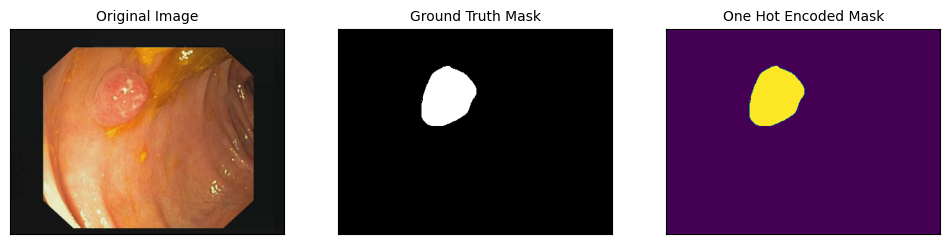

In [13]:
dataset = EndoscopyDataset(train_df, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[2]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

### Defining Augmentations

In [14]:
def get_training_augmentation():
    train_transform = [
        album.HorizontalFlip(p=0.5),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        album.PadIfNeeded(min_height=288, min_width=384, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform
    Args:
        preprocessing_fn (callable): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))

    return album.Compose(_transform)

#### Visualize Augmented Images & Masks

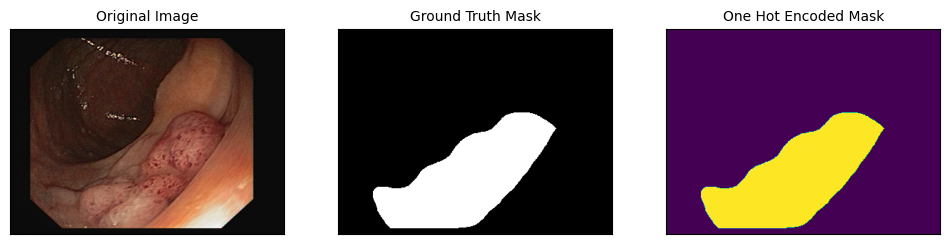

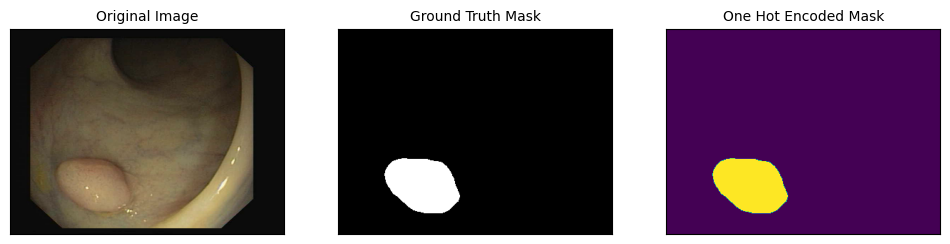

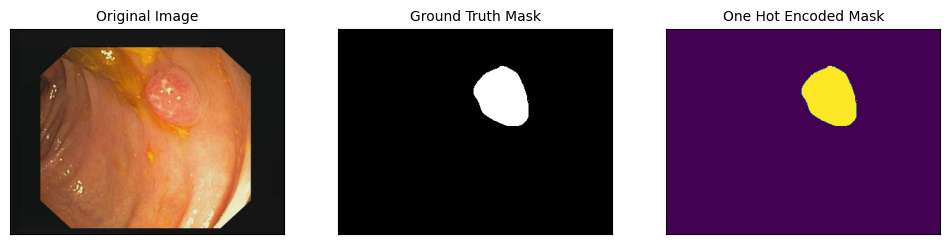

In [15]:
augmented_dataset = EndoscopyDataset(
    train_df,
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset)-1)

# Different augmentations on image/mask pairs
for idx in range(3):
    image, mask = augmented_dataset[idx]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

## Training UNet

### Model Definition

In [16]:
ENCODER = 'vgg19'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = select_classes
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:04<00:00, 132MB/s]


#### Get Train / Val DataLoaders

In [17]:
# Get train and val dataset instances
train_dataset = EndoscopyDataset(
    train_df,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

valid_dataset = EndoscopyDataset(
    valid_df,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=4)

#### Set Hyperparams

In [18]:
# pip install --upgrade segmentation-models-pytorch
# url: https://github.com/qubvel/segmentation_models.pytorch/blob/master/segmentation_models_pytorch/metrics/functional.py
# import smp_metrics
# tp, fp, fn, tn = smp_metrics.functional.ts(pred_mask.long(), mask.long(), mode="binary")

import segmentation_models_pytorch.utils.metrics



In [19]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 25

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss = smp.utils.losses.DiceLoss()
# loss = smp.losses.DiceLoss('binary')

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    # smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")
]

# define optimizer
optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.0001),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

# load best saved model checkpoint from previous commit (if present)
if os.path.exists('/content/polyp-frames/best_model.pth'):
    model = torch.load('/content/polyp-frames/best_model.pth', map_location=DEVICE)

In [20]:
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

### Training UNet

In [21]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 4/4 [00:02<00:00,  1.97it/s, dice_loss - 0.3676, iou_score - 0.6889]
Model saved!

Epoch: 1
valid: 100%|██████████| 4/4 [00:02<00:00,  1.95it/s, dice_loss - 0.275, iou_score - 0.8812]
Model saved!

Epoch: 2
valid: 100%|██████████| 4/4 [00:02<00:00,  1.44it/s, dice_loss - 0.2435, iou_score - 0.9068]
Model saved!

Epoch: 3
valid: 100%|██████████| 4/4 [00:01<00:00,  2.01it/s, dice_loss - 0.1945, iou_score - 0.9533]
Model saved!

Epoch: 4
valid: 100%|██████████| 4/4 [00:02<00:00,  1.93it/s, dice_loss - 0.1688, iou_score - 0.9518]

Epoch: 5
valid: 100%|██████████| 4/4 [00:02<00:00,  1.65it/s, dice_loss - 0.1431, iou_score - 0.9612]
Model saved!

Epoch: 6
valid: 100%|██████████| 4/4 [00:02<00:00,  1.92it/s, dice_loss - 0.1257, iou_score - 0.9659]
Model saved!

Epoch: 7
valid: 100%|██████████| 4/4 [00:02<00:00,  2.00it/s, dice_loss - 0.1096, iou_score - 0.9693]
Model saved!

Epoch: 8
valid: 100%|██████████| 4/4 [00:02<00:00,  1.98it/s, dice_loss - 0.1023, iou

### Prediction on Test Data

In [22]:
# load best saved model checkpoint from the current run
if os.path.exists('./best_model.pth'):
    best_model = torch.load('./best_model.pth', map_location=DEVICE)
    print('Loaded UNet model from this run.')

# load best saved model checkpoint from previous commit (if present)
elif os.path.exists('/content/polyp-frames/best_model.pth'):
    best_model = torch.load('/content/polyp-frames/best_model.pth', map_location=DEVICE)
    print('Loaded UNet model from a previous commit.')

Loaded UNet model from this run.


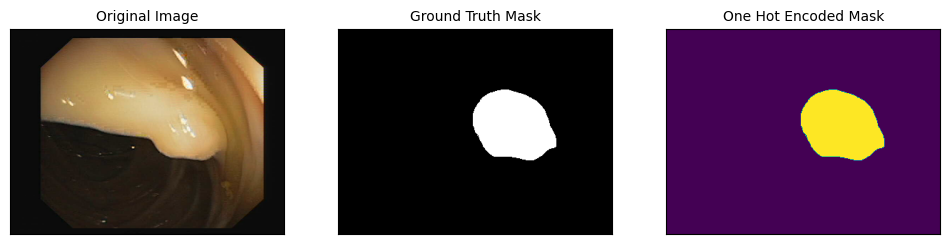

In [23]:
# create test dataloader to be used with UNet model (with preprocessing operation: to_tensor(...))
test_dataset = EndoscopyDataset(
    valid_df,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

# test dataset for visualization (without preprocessing augmentations & transformations)
test_dataset_vis = EndoscopyDataset(
    valid_df,
    class_rgb_values=select_class_rgb_values,
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

# Notice the images / masks are 1536*1536 because of 18px padding on all sides.
# This is to ensure the input image dimensions to UNet model are a multiple of 2 (to account for pooling & transpose conv. operations).

In [24]:
# Center crop padded image / mask to original image dims
def crop_image(image, true_dimensions):
    return album.CenterCrop(p=1, height=true_dimensions[0], width=true_dimensions[1])(image=image)

In [25]:
sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

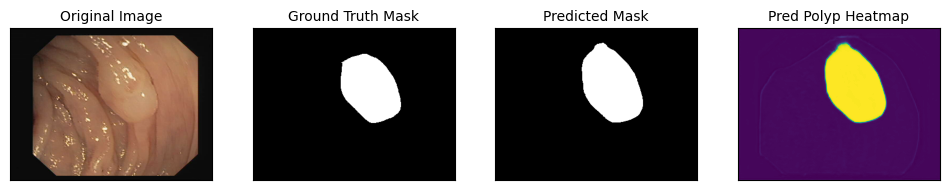

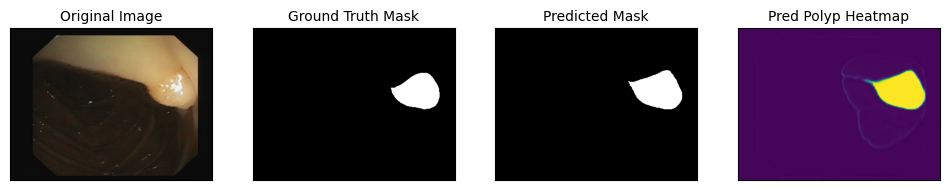

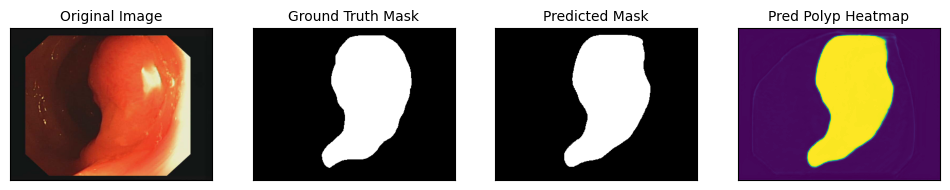

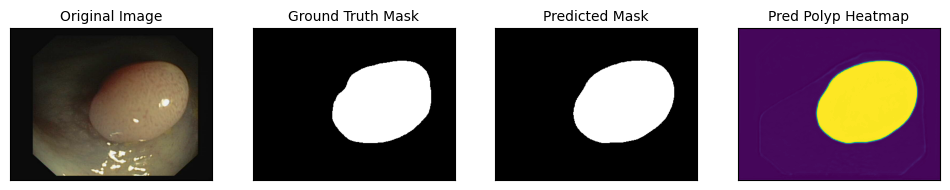

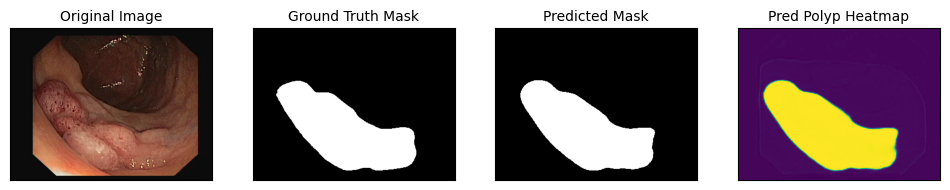

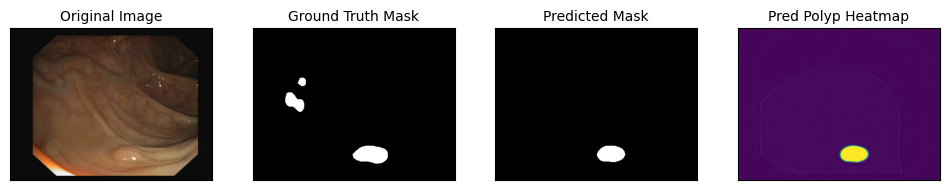

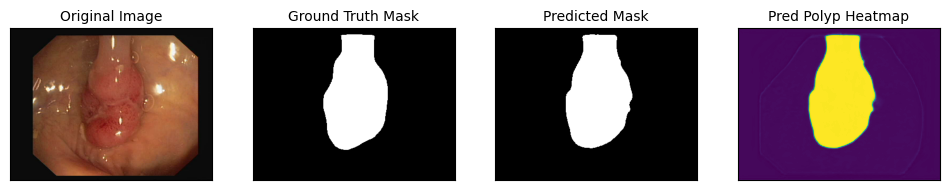

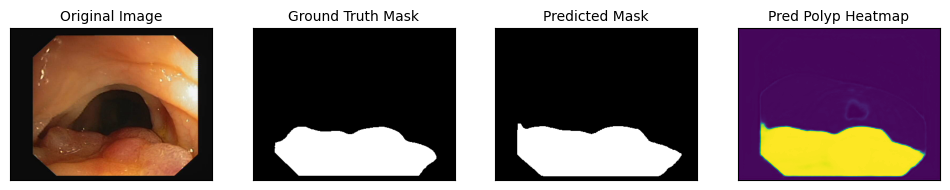

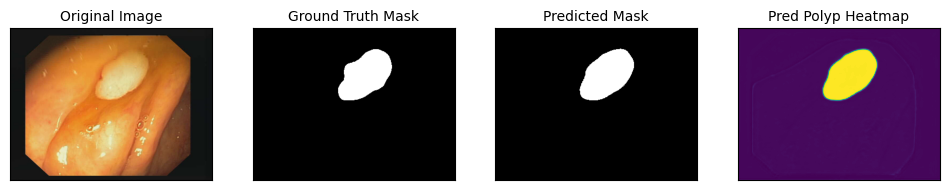

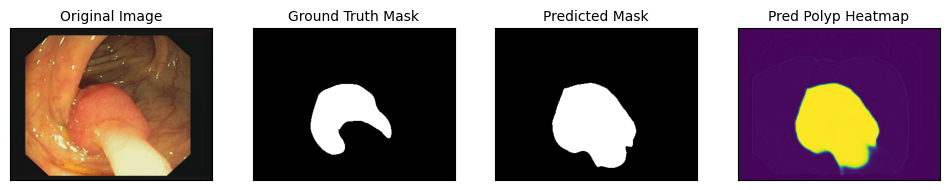

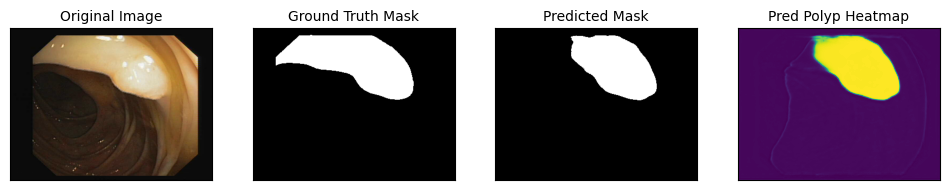

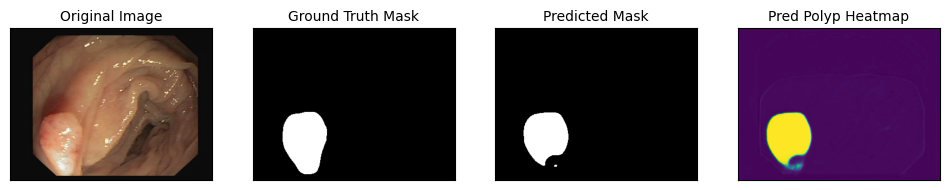

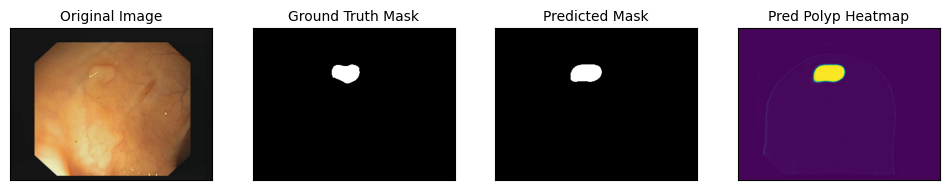

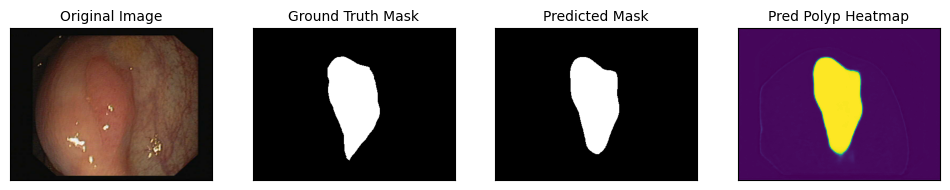

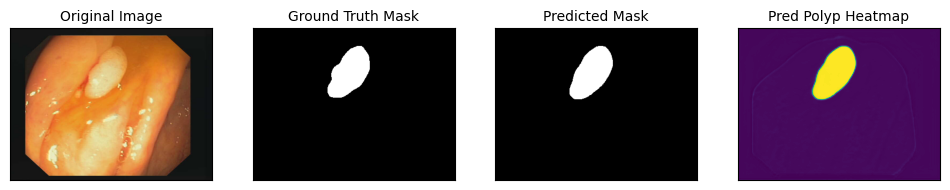

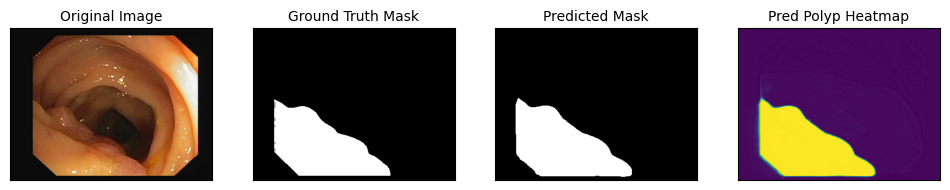

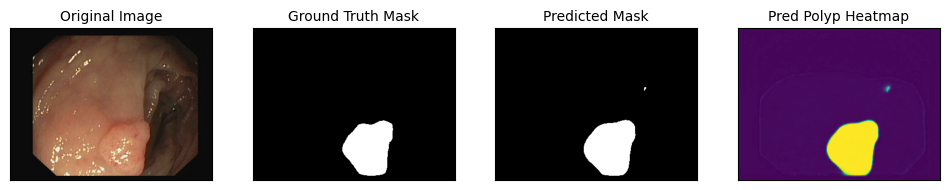

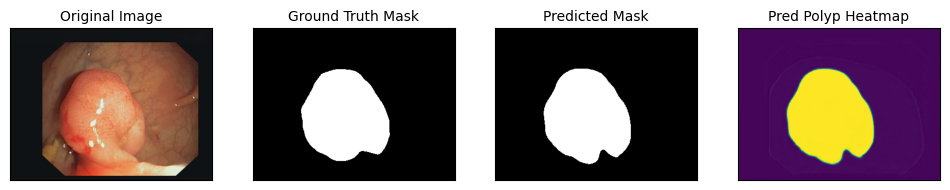

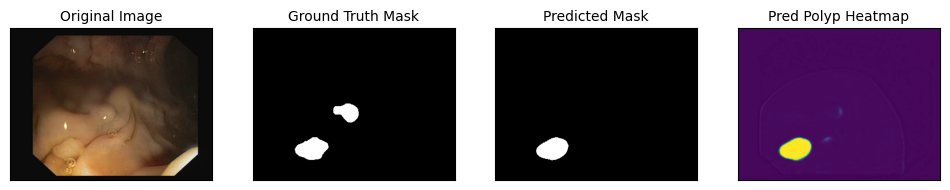

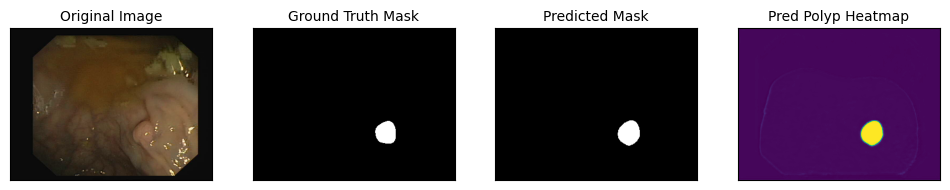

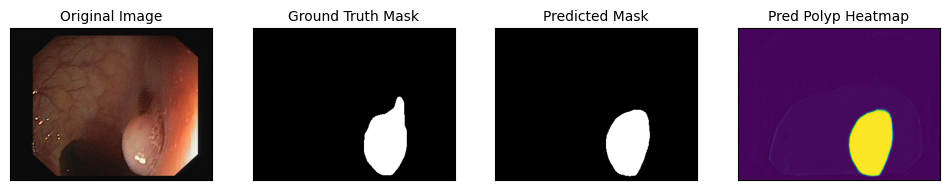

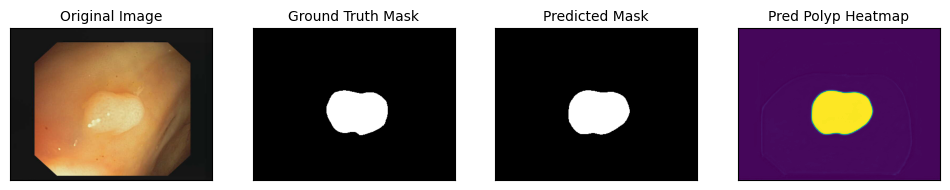

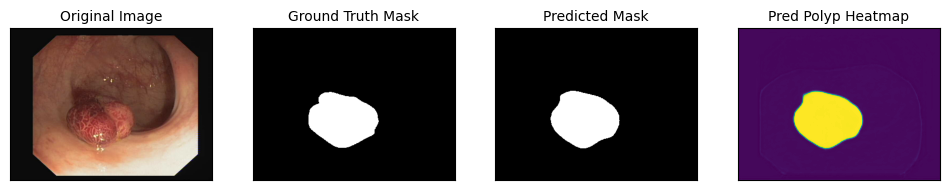

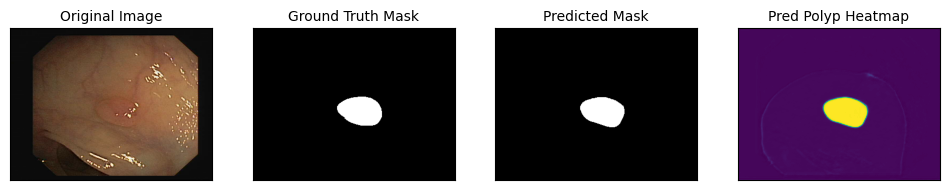

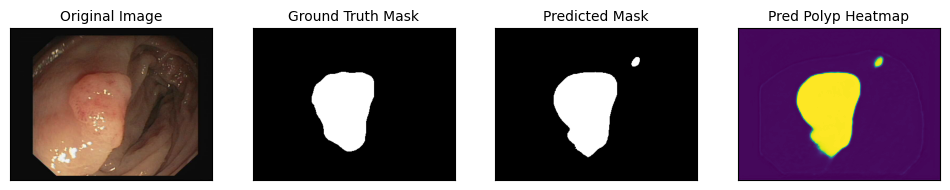

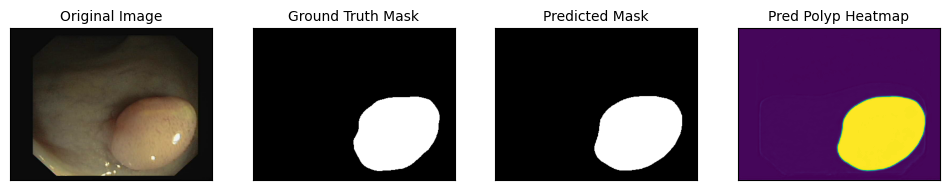

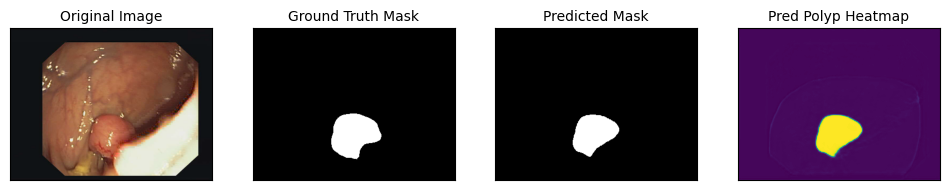

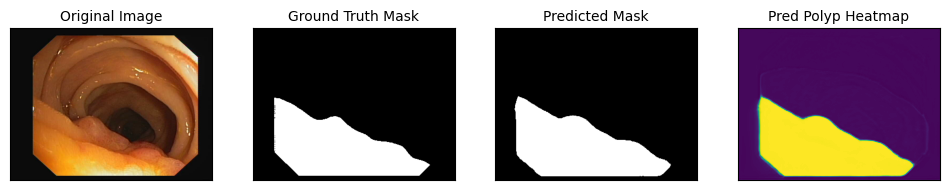

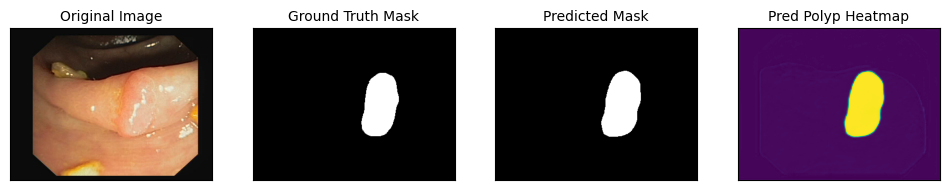

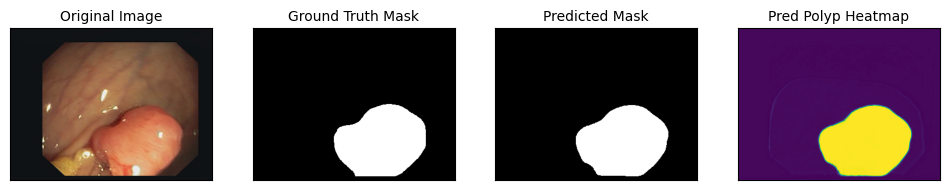

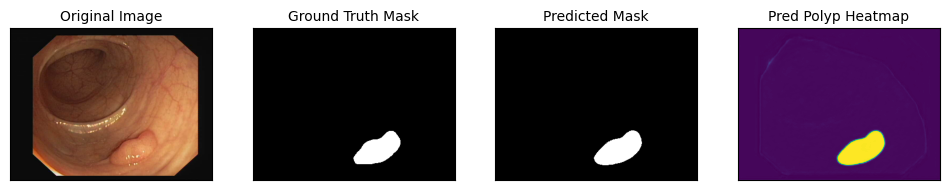

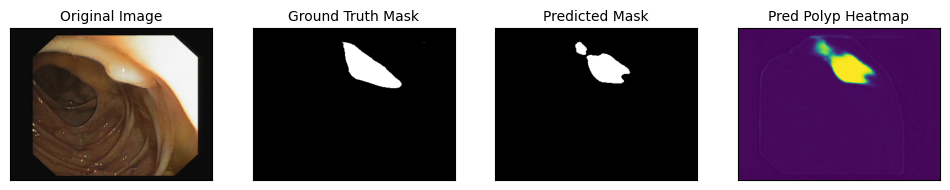

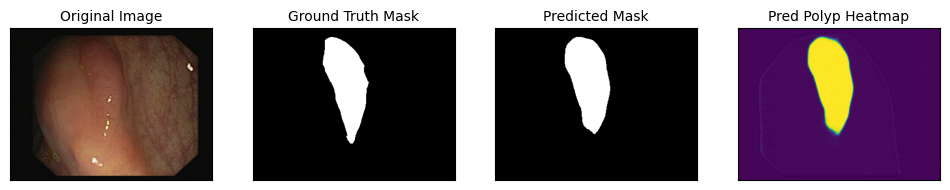

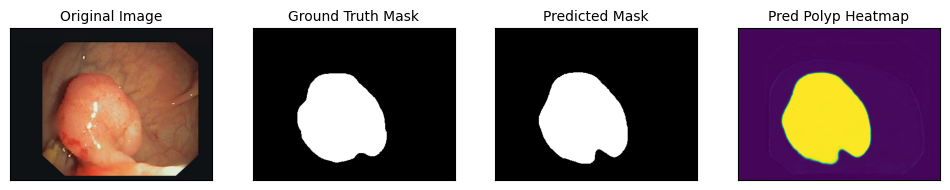

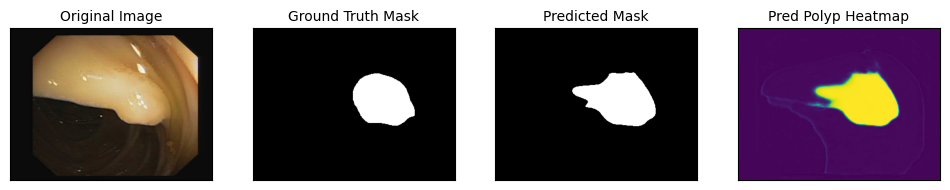

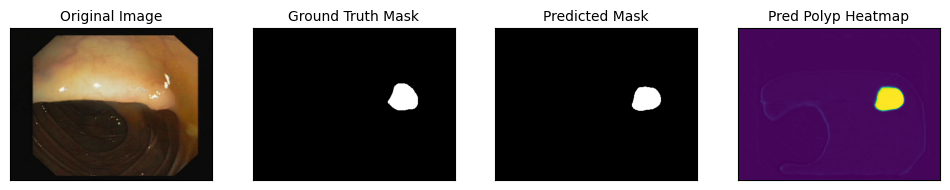

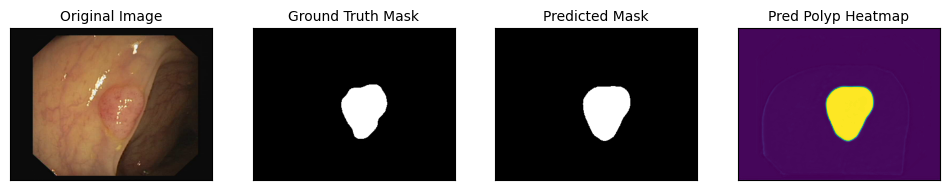

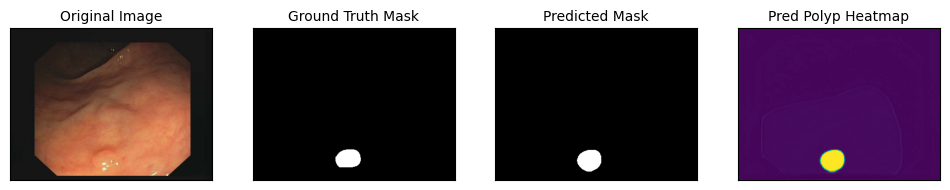

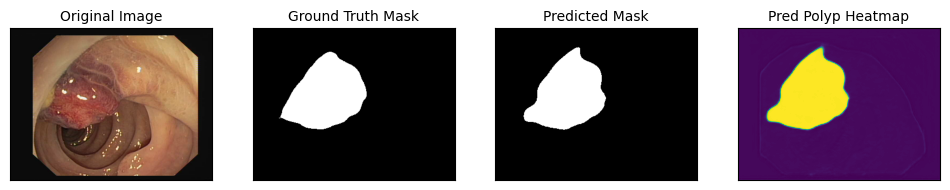

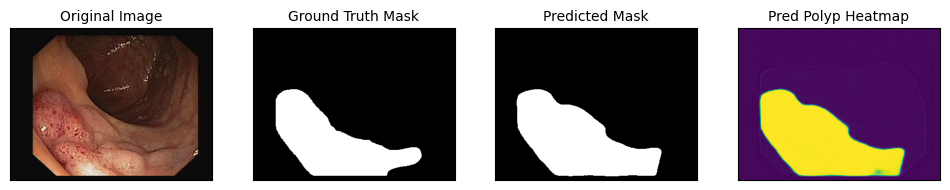

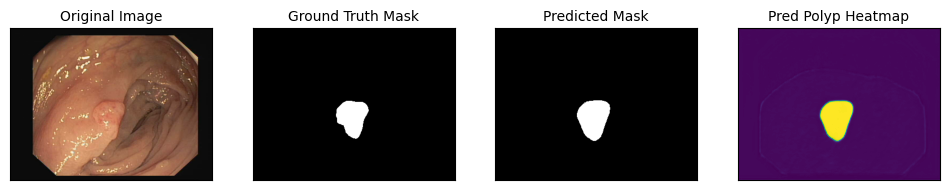

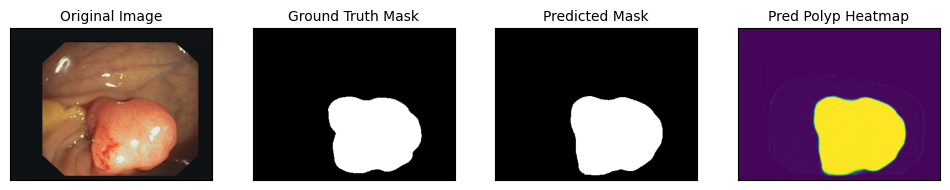

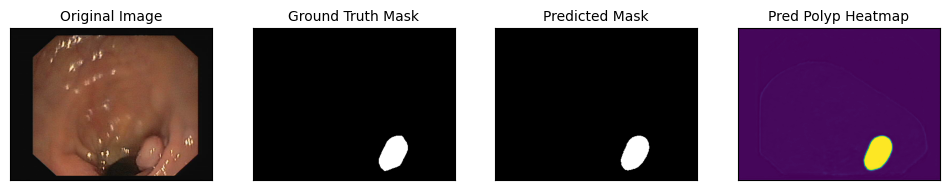

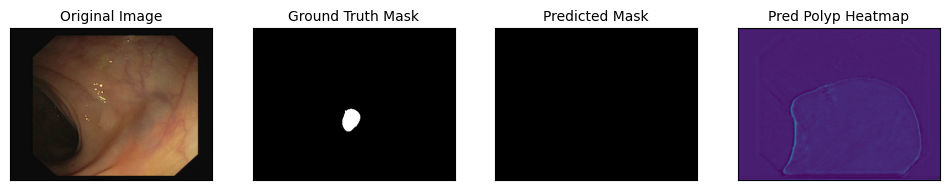

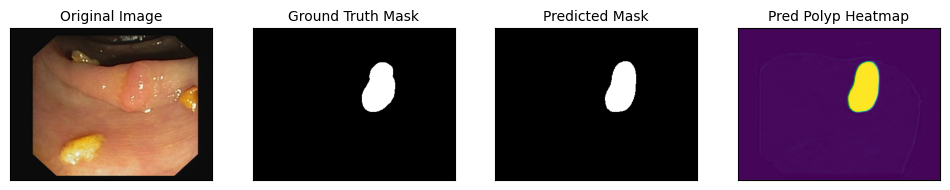

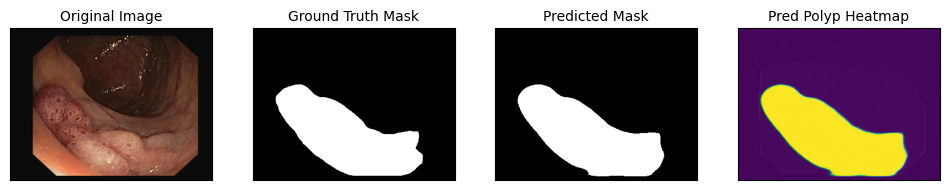

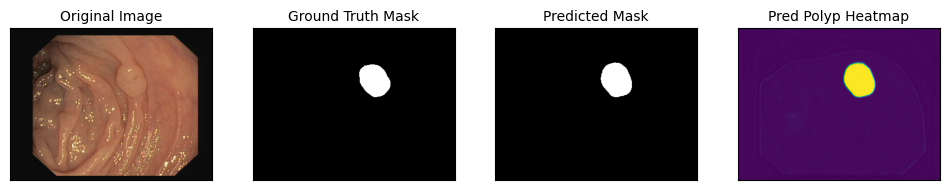

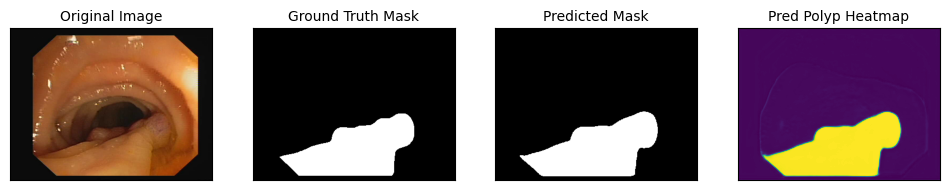

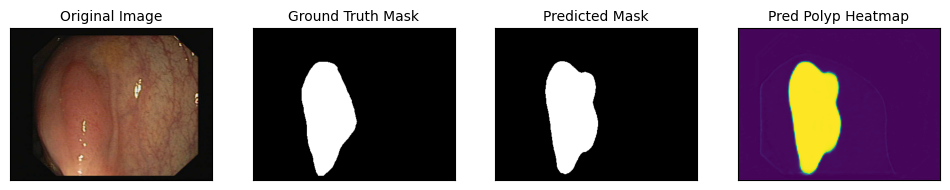

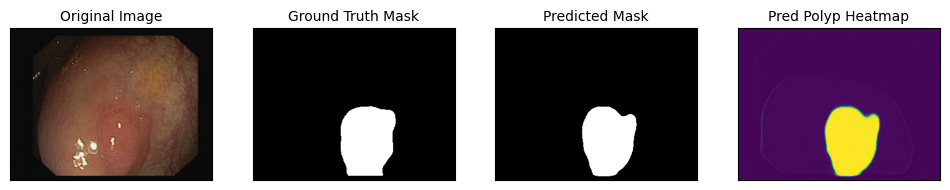

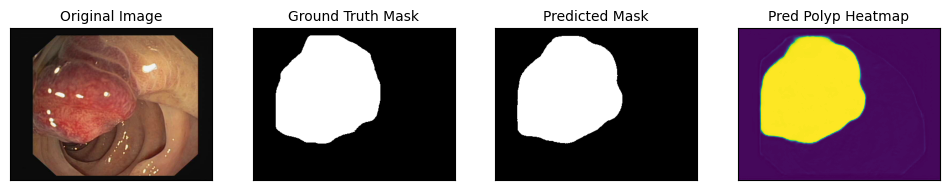

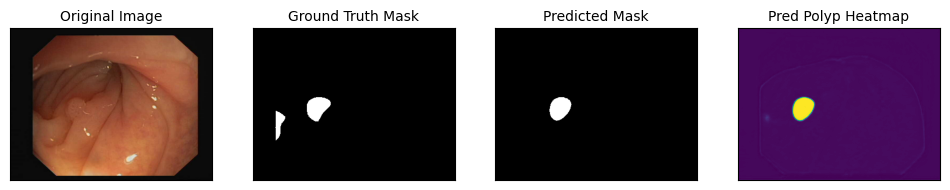

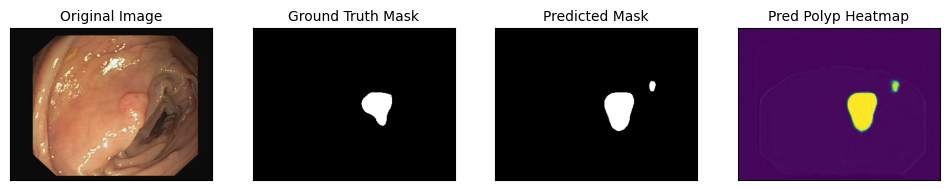

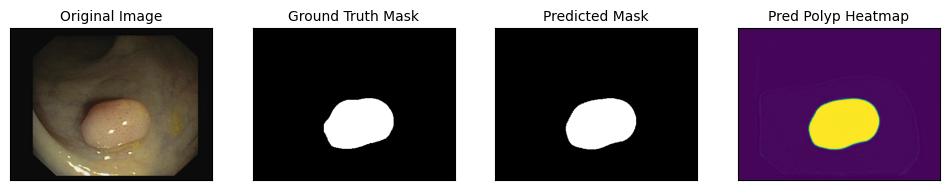

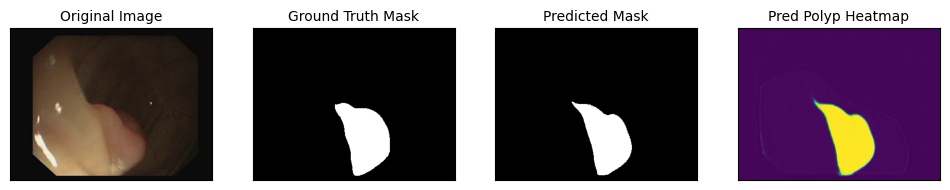

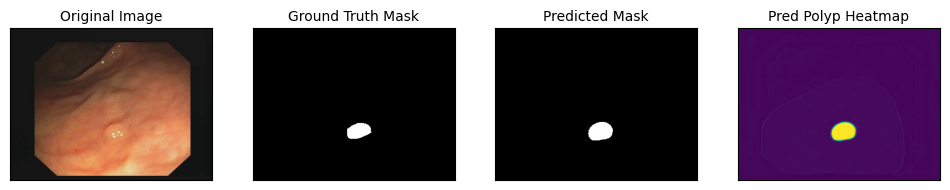

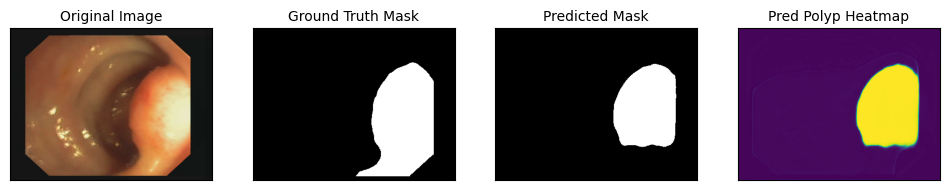

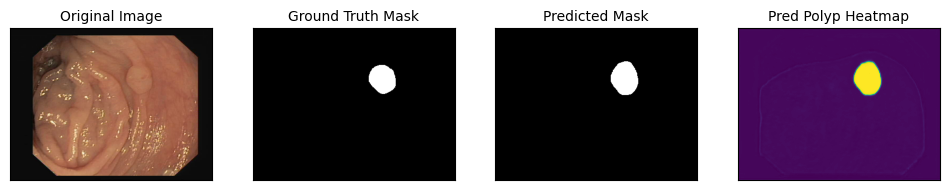

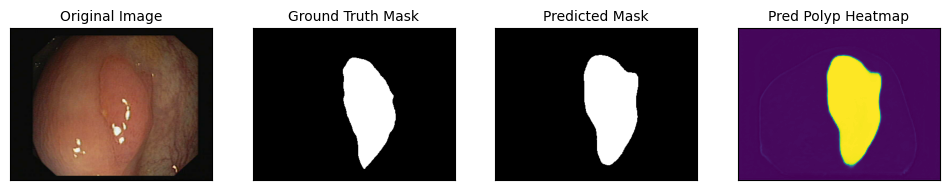

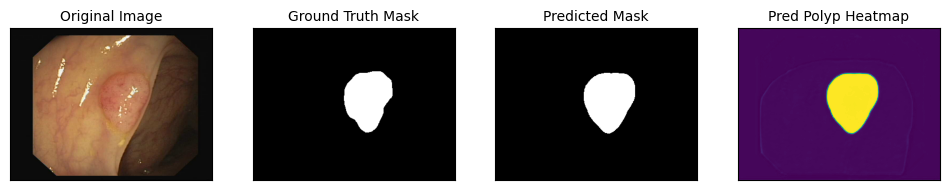

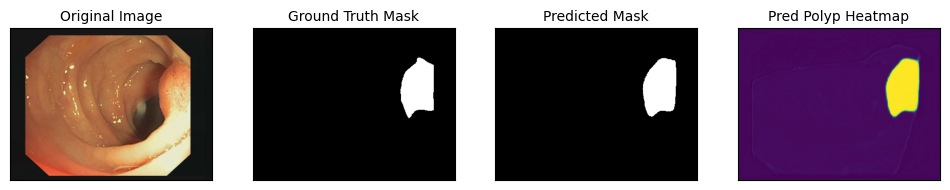

In [26]:
for idx in range(len(test_dataset)):

    image, gt_mask = test_dataset[idx]
    image_vis = test_dataset_vis[idx][0].astype('uint8')
    true_dimensions = image_vis.shape
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # Predict test image
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask,(1,2,0))
    # Get prediction channel corresponding to foreground
    pred_polyp_heatmap = crop_image(pred_mask[:,:,select_classes.index('polyp')], true_dimensions)['image']
    pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values), true_dimensions)['image']
    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = crop_image(colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values), true_dimensions)['image']
    cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])

    visualize(
        original_image = image_vis,
        ground_truth_mask = gt_mask,
        predicted_mask = pred_mask,
        pred_polyp_heatmap = pred_polyp_heatmap
    )

### Model Evaluation on Test Dataset

In [27]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

valid: 100%|██████████| 61/61 [00:02<00:00, 24.77it/s, dice_loss - 0.02869, iou_score - 0.9747]
Evaluation on Test Data: 
Mean IoU Score: 0.9747
Mean Dice Loss: 0.0287


### Plot Dice Loss & IoU Metric for Train vs. Val

In [28]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

0         1         2         3         4         5   \
dice_loss  0.404218  0.322234  0.263208  0.219911  0.187017  0.157352   
iou_score  0.586436  0.758225  0.886786  0.936996  0.947818  0.961718   

                 6         7         8         9   ...        15        16  \
dice_loss  0.135961  0.116342  0.100937  0.087535  ...  0.046153  0.041932   
iou_score  0.962692  0.969814  0.972484  0.975451  ...  0.979316  0.980849   

                 17        18        19        20        21        22  \
dice_loss  0.037736  0.036164  0.034222  0.034589  0.028947  0.026716   
iou_score  0.982906  0.980956  0.980390  0.975452  0.983311  0.984852   

                 23        24  
dice_loss  0.026297  0.023860  
iou_score  0.982849  0.985205  

[2 rows x 25 columns]

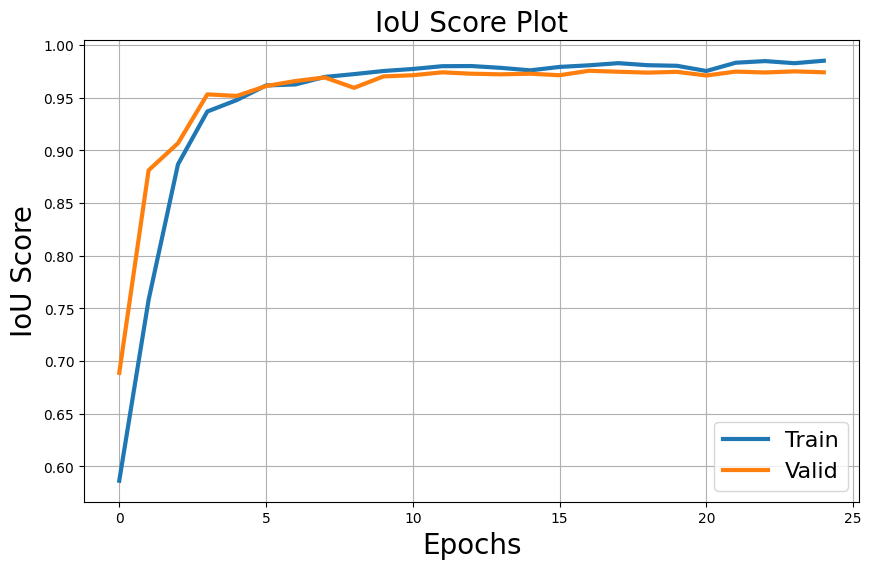

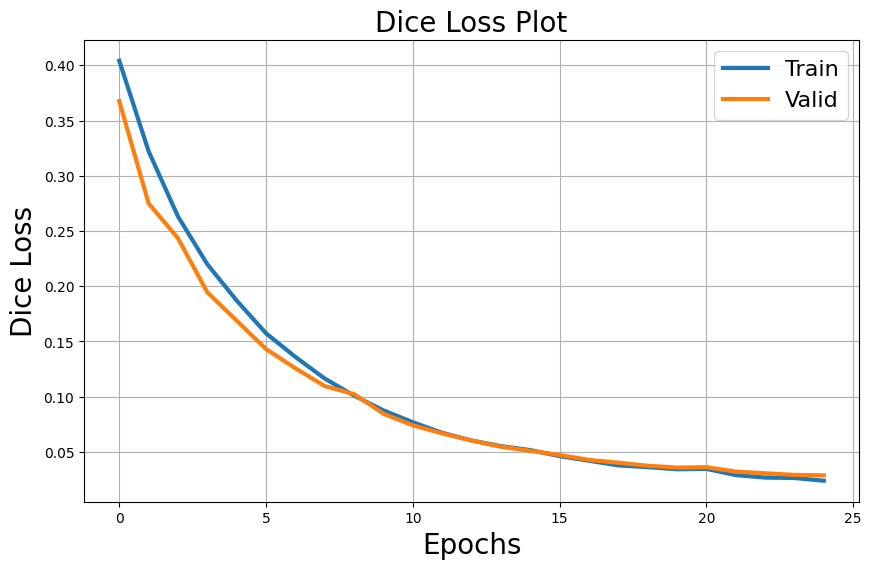

In [29]:
import matplotlib.pyplot as plt

epochs = train_logs_df.index.tolist()

# Plot IoU Score
plt.figure(figsize=(10,6))
plt.plot(epochs, train_logs_df.iou_score.tolist(), lw=3, label='Train')
plt.plot(epochs, valid_logs_df.iou_score.tolist(), lw=3, label='Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

# Plot Dice Loss
plt.figure(figsize=(10,6))
plt.plot(epochs, train_logs_df.dice_loss.tolist(), lw=3, label='Train')
plt.plot(epochs, valid_logs_df.dice_loss.tolist(), lw=3, label='Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Loss Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()


## Credits:
#### inspired from : the code of BALRAJ ASHWATH